# Setup

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Explore Database

In [3]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [4]:
# Get a list of column names and types for measurement
columns_measurement = inspector.get_columns('measurement')
for column in columns_measurement:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [5]:
# Show dataset of first 5 rows in measurement
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [6]:
# Get a list of column names and types for station
columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# Show dataset of first 5 rows in station
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Reflect Tables into SQLAlchemy ORM

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found - I used inspector above to find classes
#Base.classes.keys()

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
## Find a max date 
max_date = session.query(func.max(Measurement.date)).all()
max_date

[('2017-08-23')]

In [13]:
# Calculate the date 1 year ago from the last data point in the database
year_before_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_before_date

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= year_before_date).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])
precipitation_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [16]:
# Set index to the date column
precipitation_df.set_index('date', inplace=True)

In [17]:
# Sort the dataframe by date
sort_precipitation_df = precipitation_df.sort_values(['date'])
sort_precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


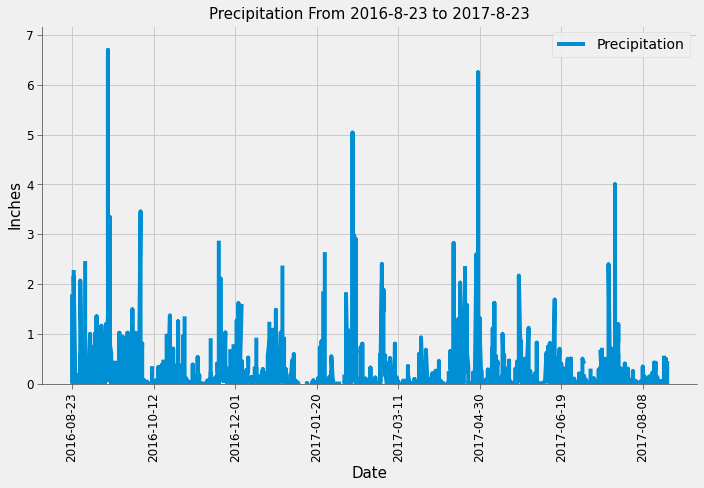

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (10, 7))

y = sort_precipitation_df['precipitation']

ax.plot(y,label='Precipitation')
ax.set_title("Precipitation From 2016-8-23 to 2017-8-23", fontsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Inches", fontsize=15)
plt.legend()

ax.xaxis.set_ticks_position('bottom')
ax.tick_params(which='major', length=5, width =0.5)
ax.xaxis.set_major_locator(ticker.AutoLocator())
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.5)
ax.set_ylim(0, 7.2)
        
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sort_precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
stations_numbers = session.query(Station.id).distinct().count()
stations_numbers

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station_data = [Measurement.station, 
                       func.min(Measurement.tobs),
                       func.max(Measurement.tobs),
                       func.avg(Measurement.tobs)]

active_station = session.query(*active_station_data).\
                    filter(Measurement.station == 'USC00519281').all()
active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations = 'USC00519281'
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.station == 'USC00519281').\
                        filter(Measurement.date >= year_before_date).all()
#temp_data

In [24]:
# Save the query results as a Pandas DataFrame
temp_df = pd.DataFrame(temp_data, columns = ['date', 'temperature'])
temp_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


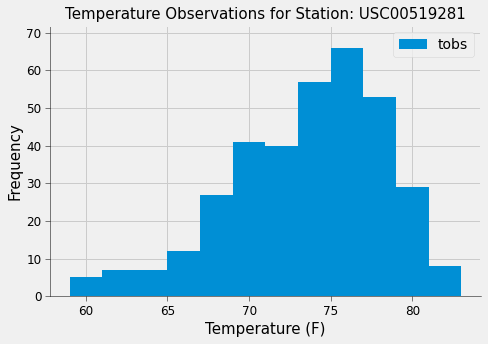

In [25]:
# Create a histogram
fig, ax = plt.subplots(figsize = (7, 5))
temp_df['temperature'].hist(bins=12, label='tobs')

ax.set_title('Temperature Observations for Station: USC00519281', fontsize=15)
ax.set_xlabel('Temperature (F)', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
plt.legend()
             
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(which='major', length=5, width =0.5)
ax.xaxis.set_major_locator(ticker.AutoLocator())
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.5)
ax.set_ylim(0, 72)
        
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [26]:
# Identify the average temperature in June at all station across all available years in the dataset
# Set up June data and Filter out null values from lists
june_data = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == "06").all()
      
# Read in pd
june_data_df = pd.DataFrame(june_data, columns = ['temperature'])

# Drop any missing data
june_data_df = june_data_df.dropna(how='any')
#june_data_df

# Average June Temperature
from numpy import mean
june_average = june_data_df.mean()
june_average

temperature    74.944118
dtype: float64

In [27]:
# Set up December data and Filter out null values from lists
december_data = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == "12").all()
      
# Read in pd
december_data_df = pd.DataFrame(december_data, columns = ['temperature'])

# Drop any missing data
december_data_df = december_data_df.dropna(how='any')
#december_data_df

# Average June Temperature
december_average = december_data_df.mean()
december_average

temperature    71.041529
dtype: float64

In [28]:
# Perform unpaired (independent) t-test becauase June and December temperature datasets are independent
from scipy import stats
stats.ttest_ind(june_data,december_data)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

### Temperature Analysis II

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_dates = '2021-05-01 to \n 2021-05-20'

trip_start_date = '2017-05-01'
trip_end_date = '2017-05-20'
# Print my trip tmin, tavg, and tmax using 2017 data

my_trip_data = calc_temps(trip_start_date, trip_end_date)
my_trip_data

[(65.0, 75.00892857142857, 80.0)]

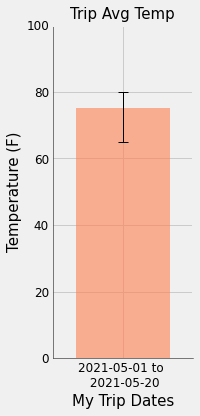

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_tmin = my_trip_data[0][0]
my_tave = my_trip_data[0][1]
my_tmax = my_trip_data[0][2]

min_yerr = my_tave - my_tmin
max_yerr = my_tmax - my_tave
errorBars = np.array([[min_yerr], [max_yerr]])

fig, ax = plt.subplots(figsize = (3, 6))

plt.bar(my_trip_dates, my_tave, yerr=errorBars, color='coral', alpha=0.6, width=2,
       error_kw=dict(lw=1, capsize=5, capthick=1))
ax.set_title("Trip Avg Temp", fontsize=15)
ax.set_xlabel("My Trip Dates", fontsize=15)
ax.set_ylabel("Temperature (F)", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.5)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0, 100)
        
plt.tight_layout()
plt.show()

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start_date = '2017-05-01'
trip_end_date = '2017-05-20'

my_precipitation_data = session.query(Measurement.station, 
                                      func.sum(Measurement.prcp), 
                                      Station.name, 
                                      Station.latitude,
                                      Station.longitude,
                                      Station.elevation).\
                        filter(Measurement.station == Station.station).\
                        filter(Measurement.date >= trip_start_date).\
                        filter(Measurement.date < trip_end_date).\
                        group_by(Measurement.station).\
                        order_by(func.sum(Measurement.prcp).desc()).all()

# Save this dataset to pd
my_precipitation_data_df = pd.DataFrame(my_precipitation_data, columns = ['station', 
                                                                          'total_rainfall', 
                                                                          'station_name',
                                                                          'latitude',
                                                                          'longitude',
                                                                          'elevation'])
my_precipitation_data_df


,station,total_rainfall,station_name,latitude,longitude,elevation
0,USC00516128,4.87,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,3.44,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,2.45,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,2.16,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519523,1.33,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.34,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


### Daily Rainfall Average

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
#daily_normals("01-01")

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = '2021-05-01'
trip_end_date = '2021-05-20'

# Use the start and end date to calculate a length of trip
# use the last two characters of trip_start and end date (day numbers)
start_day_number = int(trip_start_date[-2:])
end_day_number = int(trip_end_date[-2:])

myTripLength = end_day_number - start_day_number +1
myTripLength

20

In [35]:
# Stip off the year and save a list of %m-%d strings
stringTripStartDate = dt.datetime.strptime(trip_start_date, '%Y-%m-%d')

In [36]:
# Loop through the list of %m-%d strings and calculate the normals for each date
tripday_list = [dt.datetime.strftime(stringTripStartDate + dt.timedelta(days=x), '%m-%d')
                 for x in range (0, myTripLength)]

tripNormals = [daily_normals(date) for date in tripday_list]
tripNormals

[[(65.0, 72.75925925925925, 79.0)],
 [(65.0, 73.05084745762711, 79.0)],
 [(67.0, 73.41071428571429, 84.0)],
 [(65.0, 73.59649122807018, 78.0)],
 [(67.0, 73.39655172413794, 79.0)],
 [(66.0, 73.14035087719299, 80.0)],
 [(64.0, 71.78846153846153, 79.0)],
 [(65.0, 72.18867924528301, 80.0)],
 [(67.0, 72.9322033898305, 79.0)],
 [(64.0, 73.3157894736842, 78.0)],
 [(65.0, 73.61111111111111, 79.0)],
 [(65.0, 73.13793103448276, 79.0)],
 [(67.0, 73.14285714285714, 79.0)],
 [(63.0, 73.89285714285714, 80.0)],
 [(63.0, 73.69090909090909, 79.0)],
 [(68.0, 74.37931034482759, 80.0)],
 [(68.0, 74.45, 79.0)],
 [(68.0, 74.10714285714286, 82.0)],
 [(65.0, 73.80701754385964, 79.0)],
 [(68.0, 73.89655172413794, 79.0)]]

In [37]:
# Extract my_trip_normals to a list of lists
tripNormals = [np.array(normal[0]) for normal in tripNormals]

# Load the previous query results into a Pandas DataFrame 
tripNormals_df = pd.DataFrame(tripNormals)

# Add the `trip_dates` range with year as index
tripNormals_df['tripday_list'] = tripday_list

tripNormals_df = tripNormals_df.set_index('tripday_list')

# Rename columns
tripNormals_df = tripNormals_df.rename(columns={0: "Min Temperature", 1: "Avg Temperature", 2: "Max Temperature"})
tripNormals_df.head()

,Min Temperature,Avg Temperature,Max Temperature
tripday_list,,,
05-01,65.0,72.759259,79.0
05-02,65.0,73.050847,79.0
05-03,67.0,73.410714,84.0
05-04,65.0,73.596491,78.0
05-05,67.0,73.396552,79.0


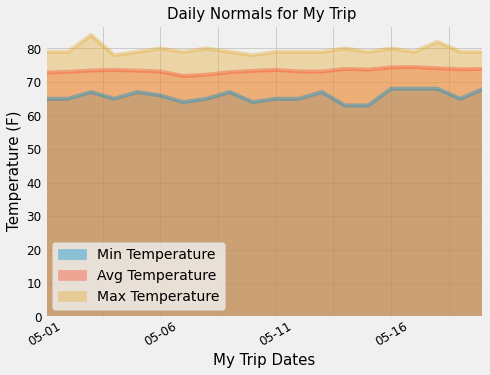

In [38]:
# Plot the daily normals as an area plot with `stacked=False'
tripNormals_df.plot.area(stacked=False, alpha=0.4, figsize=(7,5))
plt.title("Daily Normals for My Trip ", fontsize=15)
plt.xlabel("My Trip Dates", fontsize=15)
plt.ylabel("Temperature (F)", fontsize=15)

plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0, 87)
plt.xlim(0, len(tripday_list)-1)
        
plt.show()